In [186]:
#%% Imports
from pennylane import numpy as pnp # get pennylane's numpy wrapper
import numpy as np
import pennylane as qml
from itertools import combinations, groupby
import qiskit
import random
import networkx as nx
from pennylane import expval, var
from functools import partial
from collections import defaultdict
import qiskit.providers.aer.noise as noise

"""
Setup a way to construct connected graph instance problems
"""
def gnp_random_connected_graph(n, p, seed):
    """Generate a random connected graph
    n     : int, number of nodes
    p     : float in [0,1]. Probability of creating an edge
    seed  : int for initialising randomness
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = pnp.kron(pauli_z, pauli_z)

def grad_compare_qaoa_noise(graph, n_layers, NoiseModel=None, shots=None):
    # SETUP PARAMETERS
    n_wires = len(graph.nodes)
    edges = graph.edges

    def U_B(beta):
        for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)

    def U_C(gamma):
        for edge in edges:
            wire1 = edge[0]
            wire2 = edge[1]
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(gamma, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])

    analytic_dev = qml.device("default.qubit", wires=n_wires, analytic=True,)
    if shots:
        noisy_dev = qml.device("default.qubit", wires=n_wires, shots=shots, analytic=False)
    elif NoiseModel:
        noisy_dev = qml.device("default.qubit", wires=n_wires, shots=shots, analytic=False)
    
    @qml.qnode(noisy_dev)
    def noisy_circuit(gammas, betas, edge=None, n_layers=1, n_wires=1):
        for wire in range(n_wires):
            qml.Hadamard(wires=wire)
        for i in range(n_layers):
            U_C(gammas[i])
            U_B(betas[i])      
        return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

    @qml.qnode(analytic_dev)
    def analytic_circuit(gammas, betas, edge=None, n_layers=1, n_wires=1):
        for wire in range(n_wires):
            qml.Hadamard(wires=wire)
        for i in range(n_layers):
            U_C(gammas[i])
            U_B(betas[i])
        if edges is None:
            # measurement phase
            return qml.expval(comp_basis_measurement(range(n_wires)))
        return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))
    
    def noisy_objective(params, analytic=False):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in edges:
            if analytic:
                neg_obj -= 0.5 * (1 - analytic_circuit(gammas, betas, edge=edge, n_layers=n_layers, n_wires=n_wires))
            else:
                neg_obj -= 0.5 * (1 - noisy_circuit(gammas, betas, edge=edge, n_layers=n_layers, n_wires=n_wires))
        return neg_obj

    analytic_objective = partial(noisy_objective, analytic=True)

    return qml.grad(analytic_objective), qml.grad(noisy_objective)
    

In [187]:
TEST_G = gnp_random_connected_graph(4,0.2,42)

tensor([[0.00074916, 0.00080315],
        [0.00332841, 0.00663285]], requires_grad=True)

In [132]:
t1 = analytic_grad(init_params)

In [133]:
noisy_grads = []
for _ in range(50):
    noisy_grads.append(noisy_grad(init_params))

In [152]:
test = (t1-np.array(noisy_grads)).squeeze()

In [168]:
_, x, y = test.shape

In [176]:
def perform_test(shots, num_tests):
    analytic_grad, noisy_grad = grad_compare_qaoa_noise(TEST_G, 2, shots=shots)
    analytic = analytic_grad(init_params)
    noisy_grads = []
    for _ in range(num_tests):
        noisy_grads.append(noisy_grad(init_params))
    diffs = (t1-np.array(noisy_grads)).squeeze()
    _, x, y = diffs.shape
    output_arr = np.zeros((x*y, num_tests))
    ctr = 0
    for i in range(x):
        for j in range(y):     
            for k in range(num_tests):
                output_arr[ctr, k] = test[k][i,j]
            ctr += 1
    return output_arr

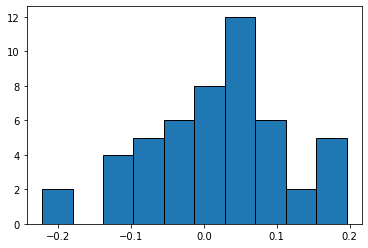

In [183]:
import matplotlib.pyplot as plt
frq, edges = np.histogram(output_arr[0,:], 10)

fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")

plt.show()

In [ ]:
num_tests = 100
shots_arr = np.linspace(1,200,32)
args = [(shots, num_tests) for shots in shots_arr]
